In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/FinancialPhraseBank-v1.0")

In [ ]:
headers = "Sentence, Sentiment\n"

In [ ]:
import pandas as pd

#I will be using Sentences_75Agree.txt from the file folder that was downloaded since this was the best balance between data set size and accuracy
headers = ["Sentence", "Sentiment"]
data = pd.read_csv("/content/drive/MyDrive/FinancialPhraseBank-v1.0/Sentences_75Agree.txt", sep="@", encoding='latin-1', names=headers)


data.head()

,Sentence,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,With the new production plant the company woul...,positive
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,"In the third quarter of 2010 , net sales incre...",positive
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3453 entries, 0 to 3452
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   3453 non-null   object
 1   Sentiment  3453 non-null   object
dtypes: object(2)
memory usage: 54.1+ KB
None


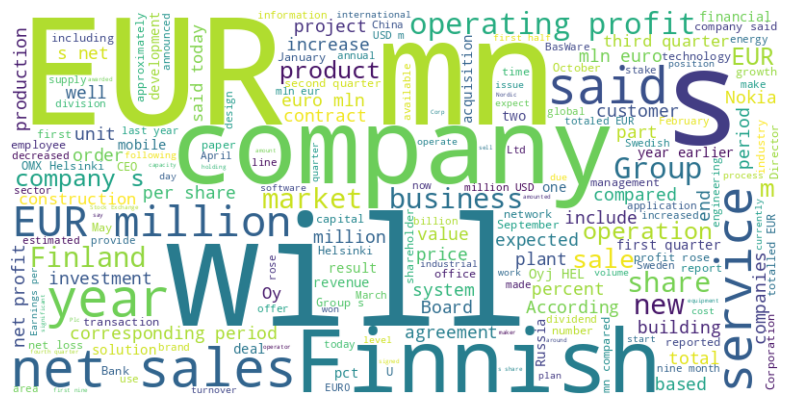

In [ ]:
#wordcloud for the financial phrasebank

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Load data
headers = ["Sentence", "Sentiment"]
data = pd.read_csv("/content/drive/MyDrive/FinancialPhraseBank-v1.0/Sentences_75Agree.txt", sep="@", encoding='latin-1', names=headers)

# Concatenate all sentences into a single string
clean_text = ' '.join(data['Sentence'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(clean_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Define bull, bear, and neutral phrases

bull_phrase = data.loc[data['Sentiment'] == 'positive']
neutral_phrase = data.loc[data['Sentiment'] == 'neutral']
bear_phrase = data.loc[data['Sentiment'] == 'negative']

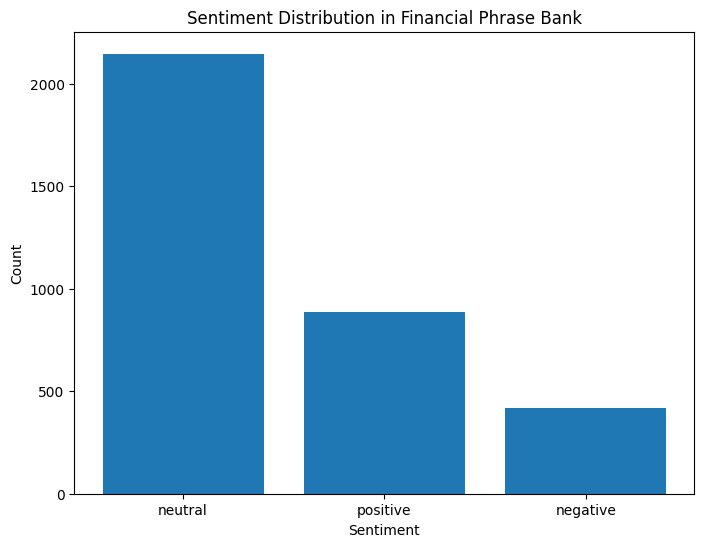

In [ ]:


# Create a bar chart for the count of each sentiment
sentiment_counts = data['Sentiment'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Financial Phrase Bank')
plt.show()



In [ ]:
sample_size = min(len(bull_phrase), len(bear_phrase), len(neutral_phrase))
print(f"Sample size for each label is: {sample_size}")

# Join equal number of bullish and bearish labelled tweets and reshuffle
df = pd.concat([
    bull_phrase.sample(n=sample_size, random_state=42),
    bear_phrase.sample(n=sample_size, random_state=42),
    neutral_phrase.sample(n=sample_size, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

df

Sample size for each label is: 420


,Sentence,Sentiment
0,"In December alone , the members of the Lithuan...",positive
1,( A spokesperson told WWD to expect a 50-50 mi...,neutral
2,Sanoma Magazines ' net sales are estimated to ...,positive
3,25 March 2011 - Finnish electronics contract m...,negative
4,17 March 2011 - Goldman Sachs estimates that t...,negative
...,...,...
1255,The final price will be specified by 14 May 20...,neutral
1256,The insurance division turned a EUR120m profit .,neutral
1257,"Weber convinced his friend Ray Ostrom , who ow...",neutral
1258,No financial details were revealed .,neutral


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#I'm going to train a linearSVC model, and optimize the model by tuning the number of features in the TF-IDF vectorizer, and what's most accurate
X_train, X_test, y_train, y_test = train_test_split(df['Sentence'], df['Sentiment'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_svm = vectorizer.fit_transform(X_train)

classifier = LinearSVC(max_iter=5000)
classifier.fit(X_train_svm, y_train)

y_pred = classifier.predict(vectorizer.transform(X_test))
print("Accuracy score: ", accuracy_score(y_test, y_pred) * 100)

Accuracy score:  73.4126984126984


In [ ]:
def get_accuracy(num_features):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=num_features)
    X_train_svm = vectorizer.fit_transform(X_train)
    classifier = LinearSVC(max_iter=5000)
    classifier.fit(X_train_svm, y_train)
    y_pred = classifier.predict(vectorizer.transform(X_test))
    return accuracy_score(y_test, y_pred) * 100

In [ ]:
accuracy_against_features = pd.DataFrame(columns = ['num_features', 'accuracy'])
min_features = 10
max_features = 1000
step = 20
for index, feature in enumerate(range(min_features, max_features, step)):
    accuracy_against_features.loc[index] = [feature, get_accuracy(feature)]

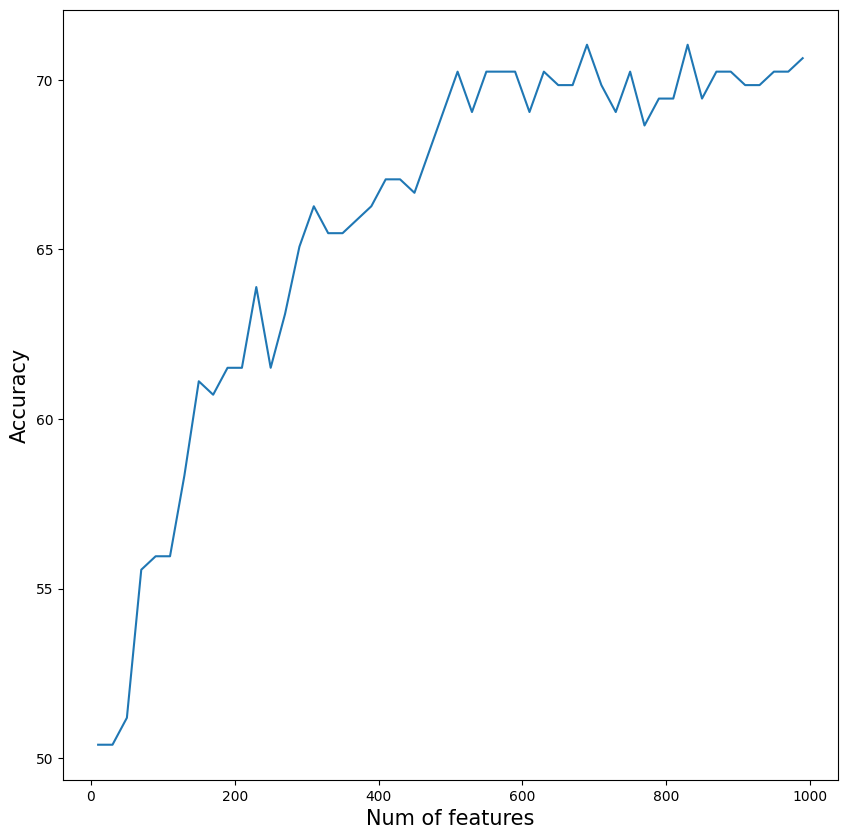

In [ ]:
num_features = accuracy_against_features['num_features']
accuracies = accuracy_against_features['accuracy']

plt.figure(figsize=(10, 10))
plt.plot(num_features, accuracies)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("Num of features", fontsize=15)
plt.show()

In [ ]:
max_row = accuracy_against_features.loc[accuracies.idxmax()]
print(f"Max accuracy is {max_row.accuracy} with {max_row.num_features} features")

Max accuracy is 71.03174603174604 with 690.0 features


The model now has a 71% accuracy on a 3 class classification. This is less than our previous model with 73% accuracy. While the difference is small, the previous model is still more accurate. I will keep the previous model.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=int(max_row.num_features))
X_train_svm = vectorizer.fit_transform(X_train)

svm_classifier = LinearSVC(max_iter=5000)
svm_classifier.fit(X_train_svm, y_train)

LinearSVC(max_iter=5000)

To train the binary classifier, I will be using the dataset stock_tweets.csv from this link:

https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction?select=stock_tweets.csv

**Dataset Information:**
The dataset contains tweets for top 25 most watched stock Stock Names on Yahoo FInance from 30-09-2021 to 30-09-2022, additionally was added stock market price and volume data for corresponding dates and stocks.

**Dataset description:**
Date - date and time of tweet
Tweet - full text of the tweet
Stock Name - full stock Stock Name name for which the tweet was scraped
Company Name - full company name for corresponding tweet and stock Stock Name

In [ ]:
#Training a binary classifier to predict the price movement of stocks
df = pd.read_csv('/content/drive/MyDrive/stock_tweets_11-11.csv')


df['Sentiment'] = svm_classifier.predict(vectorizer.transform(df.Tweet))
df.head()

,Date,Tweet,Stock Name,Company Name,Sentiment
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",neutral
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",neutral
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",neutral
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",neutral
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",positive


We will train a sentiment-based stock price predictor. This model will classify daily stock movements based on the sentiment of tweets from that day. We will group tweets by date and calculate the proportion of positive, negative, and neutral sentiment to derive features for our model.

We will then label these groups using our collect adjusted closing prices data. We will give each group a label of '1' if the price of the stock associated with the group rises after the given date, and a '0' otherwise.

I am using this Kaggle dataset: https://www.kaggle.com/datasets/svaningelgem/nasdaq-100-daily-stock-prices

I have consolidated the same stocks with data from January 2021 to Sept. 2024 for this project

In [ ]:
prices_df = pd.read_csv("/content/drive/MyDrive/archive (2)/Stocks_Consolidated.csv")
prices_df.head()

,Stock Name,date,open,high,low,close
0,AAPL,1/4/2021,131.937,132.027,125.268,127.880
1,AAPL,1/5/2021,127.362,130.173,126.902,129.445
2,AAPL,1/6/2021,126.195,129.485,124.889,125.108
3,AAPL,1/7/2021,126.834,130.063,126.334,129.355
4,AAPL,1/8/2021,130.861,131.061,128.698,130.482


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Load the financial phrases dataset
headers = ["Sentence", "Sentiment"]
data = pd.read_csv("/content/drive/MyDrive/FinancialPhraseBank-v1.0/Sentences_75Agree.txt", sep="@", encoding='latin-1', names=headers)

# Define bull, bear, and neutral phrases
bull_phrase = data.loc[data['Sentiment'] == 'positive']
neutral_phrase = data.loc[data['Sentiment'] == 'neutral']
bear_phrase = data.loc[data['Sentiment'] == 'negative']
sample_size = min(len(bull_phrase), len(bear_phrase), len(neutral_phrase))

# Join equal number of bullish, bearish, and neutral phrases and reshuffle
df = pd.concat([
    bull_phrase.sample(n=sample_size, random_state=42),
    bear_phrase.sample(n=sample_size, random_state=42),
    neutral_phrase.sample(n=sample_size, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Split data for training
X_train, X_test, y_train, y_test = train_test_split(df['Sentence'], df['Sentiment'], test_size=0.2, random_state=42)

# Train a LinearSVC model
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_svm = vectorizer.fit_transform(X_train)

classifier = LinearSVC(max_iter=5000)
classifier.fit(X_train_svm, y_train)

# Predict sentiment for the test set
y_pred = classifier.predict(vectorizer.transform(X_test))
print("Accuracy score: ", accuracy_score(y_test, y_pred) * 100)

# Function to get accuracy based on number of features
def get_accuracy(num_features):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=num_features)
    X_train_svm = vectorizer.fit_transform(X_train)
    classifier = LinearSVC(max_iter=5000)
    classifier.fit(X_train_svm, y_train)
    y_pred = classifier.predict(vectorizer.transform(X_test))
    return accuracy_score(y_test, y_pred) * 100

# Check accuracy against features
accuracy_against_features = pd.DataFrame(columns=['num_features', 'accuracy'])
min_features = 10
max_features = 1000
step = 20
for index, feature in enumerate(range(min_features, max_features, step)):
    accuracy_against_features.loc[index] = [feature, get_accuracy(feature)]

# Find max accuracy
max_row = accuracy_against_features.loc[accuracy_against_features['accuracy'].idxmax()]
print(f"Max accuracy is {max_row.accuracy} with {max_row.num_features} features")

# Retrain with the best number of features
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=int(max_row.num_features))
X_train_svm = vectorizer.fit_transform(X_train)

svm_classifier = LinearSVC(max_iter=5000)
svm_classifier.fit(X_train_svm, y_train)

# Load the tweets dataset
df_tweets = pd.read_csv('/content/drive/MyDrive/stock_tweets_11-11.csv')

# Ensure the 'Date' column is in datetime format
df_tweets['Date'] = pd.to_datetime(df_tweets['Date'])

# Group tweets by stock name and date, and count the sentiments
sentiment_counts = df_tweets.groupby(['Stock Name', 'Date', 'Sentiment']).size().unstack(fill_value=0)

# Rename the columns to match the required features
sentiment_counts.columns = ['negative_tweets', 'neutral_tweets', 'positive_tweets']

# Reset index to turn the grouped data back into a DataFrame
sentiment_counts = sentiment_counts.reset_index()

# Display the aggregated sentiment counts
print(sentiment_counts.head())

# Load stock prices data
prices_df = pd.read_csv("/content/drive/MyDrive/archive (2)/Stocks_Consolidated.csv")

# Ensure the 'Date' column is in datetime format in prices_df
prices_df['Date'] = pd.to_datetime(prices_df['Date'])

# Merge the sentiment counts with the stock prices DataFrame
merged_df = pd.merge(prices_df, sentiment_counts, on=['Stock Name', 'Date'], how='left')

# Fill NaN values with 0 (if

Accuracy score:  73.4126984126984
Max accuracy is 71.03174603174604 with 690.0 features


KeyError: 'Sentiment'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Load the financial phrases dataset
headers = ["Sentence", "Sentiment"]
data = pd.read_csv("/content/drive/MyDrive/FinancialPhraseBank-v1.0/Sentences_75Agree.txt", sep="@", encoding='latin-1', names=headers)

# Define bull, bear, and neutral phrases
bull_phrase = data.loc[data['Sentiment'] == 'positive']
neutral_phrase = data.loc[data['Sentiment'] == 'neutral']
bear_phrase = data.loc[data['Sentiment'] == 'negative']
sample_size = min(len(bull_phrase), len(bear_phrase), len(neutral_phrase))

# Join equal number of bullish, bearish, and neutral phrases and reshuffle
df = pd.concat([
    bull_phrase.sample(n=sample_size, random_state=42),
    bear_phrase.sample(n=sample_size, random_state=42),
    neutral_phrase.sample(n=sample_size, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Split data for training
X_train, X_test, y_train, y_test = train_test_split(df['Sentence'], df['Sentiment'], test_size=0.2, random_state=42)

# Train a LinearSVC model
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_svm = vectorizer.fit_transform(X_train)

classifier = LinearSVC(max_iter=5000)
classifier.fit(X_train_svm, y_train)

# Predict sentiment for the test set
y_pred = classifier.predict(vectorizer.transform(X_test))
print("Accuracy score: ", accuracy_score(y_test, y_pred) * 100)

# Function to get accuracy based on number of features
def get_accuracy(num_features):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=num_features)
    X_train_svm = vectorizer.fit_transform(X_train)
    classifier = LinearSVC(max_iter=5000)
    classifier.fit(X_train_svm, y_train)
    y_pred = classifier.predict(vectorizer.transform(X_test))
    return accuracy_score(y_test, y_pred) * 100

# Check accuracy against features
accuracy_against_features = pd.DataFrame(columns=['num_features', 'accuracy'])
min_features = 10
max_features = 1000
step = 20
for index, feature in enumerate(range(min_features, max_features, step)):
    accuracy_against_features.loc[index] = [feature, get_accuracy(feature)]

# Find max accuracy
max_row = accuracy_against_features.loc[accuracy_against_features['accuracy'].idxmax()]
print(f"Max accuracy is {max_row.accuracy} with {max_row.num_features} features")

# Retrain with the best number of features
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=int(max_row.num_features))
X_train_svm = vectorizer.fit_transform(X_train)

svm_classifier = LinearSVC(max_iter=5000)
svm_classifier.fit(X_train_svm, y_train)

# Load the tweets dataset
df_tweets = pd.read_csv('/content/drive/MyDrive/stock_tweets_11-11.csv')

# Ensure the 'Date' column is in datetime format
df_tweets['Date'] = pd.to_datetime(df_tweets['Date'])

# Predict sentiment for the tweets
df_tweets['Sentiment'] = svm_classifier.predict(vectorizer.transform(df_tweets['Tweet']))

# Group tweets by stock name and date, and count the sentiments
sentiment_counts = df_tweets.groupby(['Stock Name', 'Date', 'Sentiment']).size().unstack(fill_value=0)

# Rename the columns to match the required features
sentiment_counts.columns = ['negative_tweets', 'neutral_tweets', 'positive_tweets']

# Reset index to turn the grouped data back into a DataFrame
sentiment_counts = sentiment_counts.reset_index()

# Display the aggregated sentiment counts
print(sentiment_counts.head())

Accuracy score:  73.4126984126984
Max accuracy is 71.03174603174604 with 690.0 features
  Stock Name                      Date  negative_tweets  neutral_tweets  \
0       AAPL 2021-09-30 10:19:31+00:00                0               0   
1       AAPL 2021-09-30 10:22:53+00:00                0               1   
2       AAPL 2021-09-30 13:36:10+00:00                0               0   
3       AAPL 2021-09-30 15:30:03+00:00                0               0   
4       AAPL 2021-09-30 15:37:52+00:00                0               0   

   positive_tweets  
0                1  
1                0  
2                1  
3                1  
4                1  
